In [ ]:
!nvcc --version 
!pip install -U mxnet-cu101==1.7.0    
#version was 1.7.0
!pip install --upgrade gluoncv
!pip install decord

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
     |███████████████████████████████▌| 834.1 MB 1.5 MB/s eta 0:00:08tcmalloc: large alloc 1147494400 bytes == 0x5604b2356000 @  0x7fb8f8e37615 0x5604786663bc 0x56047874718a 0x5604786691cd 0x56047875bb3d 0x5604786dd458 0x5604786d802f 0x56047866aaba 0x5604786dd2c0 0x5604786d802f 0x56047866aaba 0x5604786d9cd4 0x56047875c986 0x5604786d9350 0x56047875c986 0x5604786d9350 0x56047875c986 0x5604786d9350 0x56047866af19 0x5604786aea79 0x560478669b32 0x5604786dd1dd 0x5604786d802f 0x56047866aaba 0x5604786d9cd4 0x5604786d802f 0x56047866aaba 0x5604786d8eae 0x56047866a9da 0x5604786d9108 0x5604786d802f
     |████████████████████████████████| 846.0 MB 20 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalle

In [ ]:


from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np

import pandas
from decord import VideoReader

import mxnet as mx
import gluoncv 
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
import gluoncv.data 
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
#https://medium.com/apache-mxnet/gluoncv-0-6-embrace-video-understanding-49bc10ec1421

num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
  # video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.9]), #WAS THIS  scale_ratios=[1.0, 0.875, 0.75, 0.66]
    # Randomly flip the video frames horizontally
   # video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
   # video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

per_device_batch_size = 16 #change batch size over here 
num_workers = 0 # these two lines are used if we were trying to use multiple gpus - so ignore
batch_size = per_device_batch_size * num_gpus

val_dataset = VideoClsCustom(root=os.path.expanduser('/content/drive/MyDrive/sl_videos/'),#bounded_videos/'),
                               setting=os.path.expanduser('/content/drive/MyDrive/sl_videos/new_val.txt'),
                               train=False,
                               video_loader=True,
                               use_decord=True,
                               #video_ext = 'mp4',
                                new_step =2 ,
                               new_length=32,
                               new_width = 224,
                               new_height = 224,
                               transform=transform_train
                               )


print('Load %d training samples.' % len(val_dataset))
val_data = gluon.data.DataLoader(val_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)


Load 353 training samples.


In [ ]:
#net = gluoncv.model_zoo.slowfast_4x16_resnet50_kinetics400(nclass=50, pretrained_base=True, num_segments=1, ctx=ctx)#check num_segments
#net = get_model(name='i3d_resnet50_v1_custom', nclass=2)
#kinetics_model = get_model(name='slowfast_8x8_resnet101_kinetics400', nclass=400, pretrained=True)
net = get_model(name='i3d_resnet50_v1_custom',nclass=50,pretrained=False,pretrained_base=True,feat_ext=False,partial_bn=True)

                   
                      
                    

# source_params = kinetics_model.collect_params()
# target_params = net.collect_params()
# assert len(source_params.keys()) == len(target_params.keys())

# pretrained_weights=[]
# for layer_name in source_params.keys():
#     pretrained_weights.append(source_params[layer_name].data())

# for i, layer_name in enumerate(target_params.keys()):
#     if i + 2 == len(source_params.keys()):
#         # skip the last dense layer
#         break
#     target_params[layer_name].set_data(pretrained_weights[i])

# net.collect_params().reset_ctx(ctx)


net.collect_params().reset_ctx(ctx)
net.collect_params().reset_ctx(mx.Context('cpu'))
net.load_parameters('/content/drive/MyDrive/BEST_MODEL_WEIGHTS_finetune65.params')
net.collect_params().reset_ctx(mx.Context('gpu'))

conv4_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm4_gamma is done with shape:  (64,)
batchnorm4_beta is done with shape:  (64,)
batchnorm4_running_mean is done with shape:  (64,)
batchnorm4_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

In [ ]:
net.collect_params().setattr('grad_req', 'null')

{9: 'school', 10: 'sister', 14: 'what', 16: 'friend', 17: 'sit', 13: 'bird', 11: 'finish', 18: 'mother', 15: 'tired', 12: 'white', 19: 'yes', 24: 'fish', 21: 'learn', 20: 'student', 27: 'table', 23: 'good', 25: 'again', 0: 'nice', 22: 'spring', 26: 'sad', 1: 'teacher', 31: 'milk', 36: 'nothing', 30: 'father', 34: 'paper', 29: 'where', 33: 'brother', 28: 'need', 32: 'cousin', 35: 'forget', 40: 'black', 45: 'bored', 2: 'eat', 39: 'fine', 38: 'girl', 37: 'book', 43: 'family', 44: 'hearing', 41: 'boy', 42: 'lost', 7: 'want', 48: 'computer', 47: 'water', 46: 'please', 5: 'like', 49: 'help', 4: 'happy', 8: 'deaf', 6: 'orange', 3: 'no'}
_______________________________________________________________________
_________________________________0_____________________________________
_______________________________________________________________________
353
val=0.847025
EvalMetric: {'top_k_accuracy_3': 0.9660056657223796}
EvalMetric: {'top_k_accuracy_5': 0.9745042492917847}
353
353
Classification 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Accuracy:  0.8470254957507082
F1 0.8445968583425938


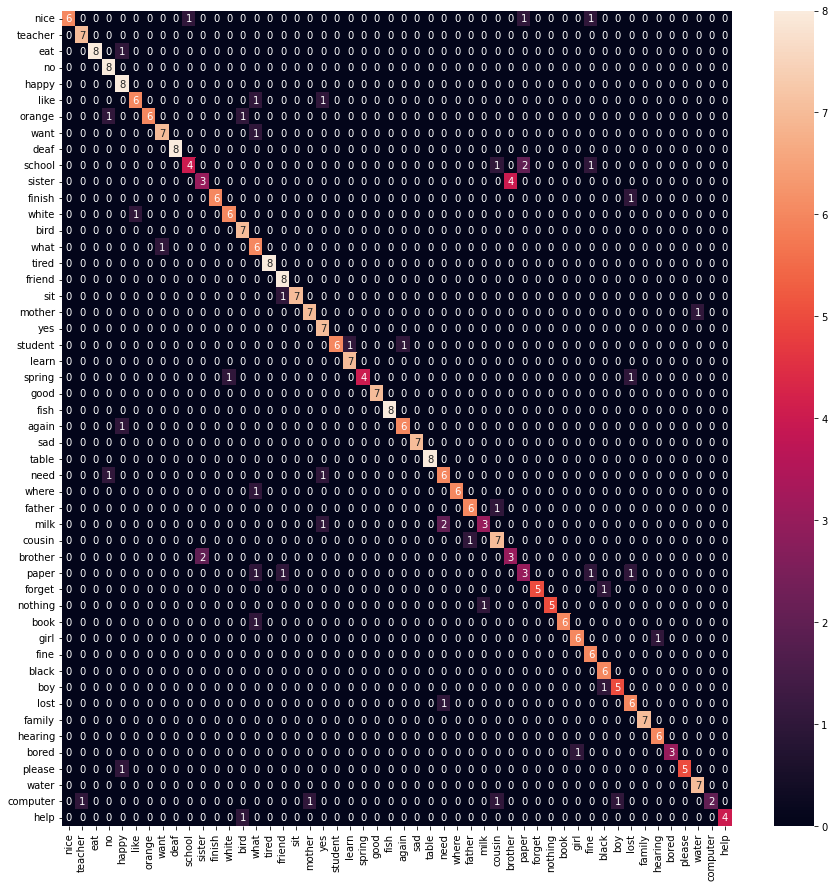

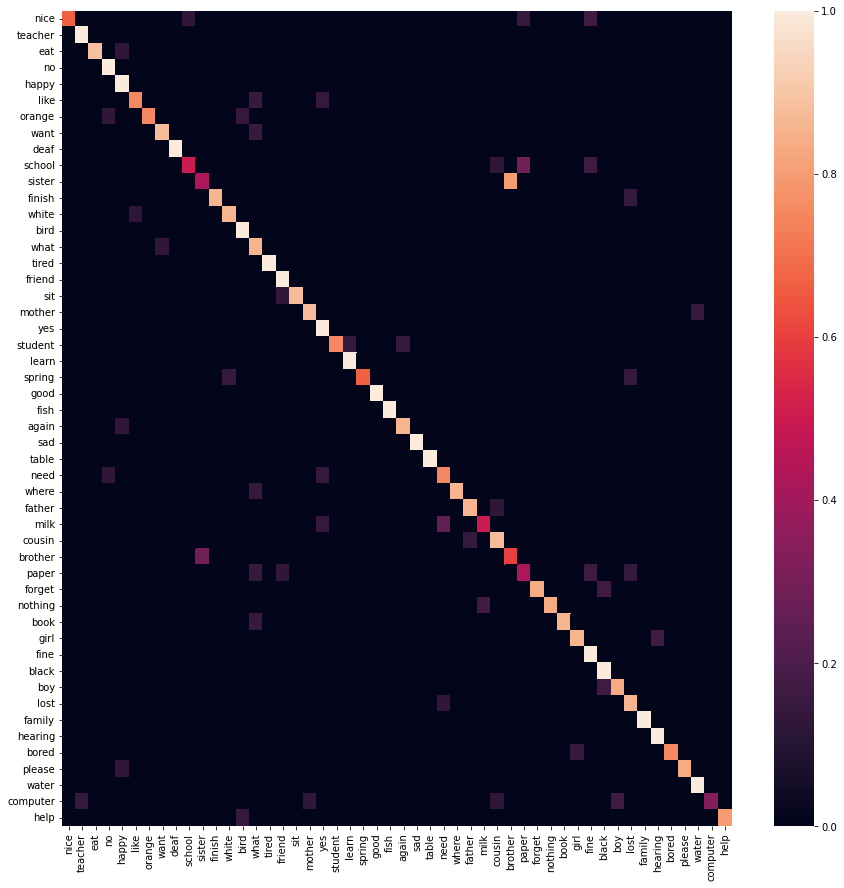

In [ ]:
import os
import pandas as pd
import random
import shutil

class_str = []
class_str_dict = {}
for word in os.listdir('/content/drive/MyDrive/sl_videos/bounded_padded_videos'):   #CHANGE
    class_str.append(word)
for work in class_str:
  seperate = work.split('_')
  num = int(seperate[0])
  num  = num-1
  c = str(seperate[1])
  class_str_dict[num] =  c
  class_str = []
for i in range(len(class_str_dict)):
    class_str.append(class_str_dict[i])

print(class_str_dict)




from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math as m
import matplotlib.pyplot as plt

for xit in range(1):
  print("_______________________________________________________________________")
  print("_________________________________"+str(xit)+"_____________________________________")
  print("_______________________________________________________________________")
  k = []
  for i in range(50):
    k.append(i)
  val_metric = mx.metric.Accuracy()
  val2 = mx.metric.TopKAccuracy(top_k = 3)
  val3 = mx.metric.TopKAccuracy(top_k = 5)
  val3.reset()
  val2.reset()
  val_metric.reset()
  y_true = []
  predictions_valid = []
  y_pred = []
  print(len(val_dataset))
  for i, batch in enumerate(val_data): # here change accordingly whether val or train
          
          #print(i)
          # print(len(val_data))
          # if i==m.ceil(len(val_dataset)/16): # declare these 2 variables and also change according with val and train
          #   break
          data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
          label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
          y_true = y_true + label[0].asnumpy().tolist()
          val_output = []
          for _, X in enumerate(data):
              X = X.reshape((-1,) + X.shape[2:])
              #print(X.shape)
              pred = net(X)
              val_output.append(pred)
              predictions_valid  = predictions_valid + pred.asnumpy().tolist()
          val_metric.update(label, val_output)

          val2.update(label, val_output)
          val3.update(label, val_output)

  name_val, val_acc = val_metric.get()
  print('val=%f'  %(val_acc))
  print(val2)
  print(val3)
  
  for i in range(0,len(predictions_valid)):
      y_pred = y_pred + [np.argmax(predictions_valid[i])]

  print(len(y_pred))
  print(len(y_true))

  score = accuracy_score(y_true, y_pred)
  print('Classification Report: ',classification_report(y_true,y_pred))
  cm = confusion_matrix(y_true, y_pred)
  norm_cm = cm / cm.astype(np.float).sum(axis=1)

  f,ax= plt.subplots(figsize=(15, 15))
  sns.heatmap(cm,annot = True, fmt='g', ax=ax,) #annot=True to annotate cells, ftm='g' to disable scientific notation

  #labels, title and ticks
  #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  #ax.set_title('Confusion Matrix');
  classes_rev = []

  classes = k
  l = 50
  for i in range(1,l+1):
      classes_rev = classes_rev + [classes[l-i]]
  ax.xaxis.set_ticklabels(class_str);ax.yaxis.set_ticklabels(class_str);
  plt.yticks(rotation='horizontal')
  plt.xticks(rotation=90)
  #ax.xaxis.set_ticklabels(classes);ax.yaxis.set_ticklabels(classes);
  ax.figure.savefig("for referennce_i3d_resnet_50_ft_1_e65"+str(xit)+".png",dpi=500)        #CHANGE FILE NAME 

  #----------------------------------------------
  f,ax= plt.subplots(figsize=(15, 15))
  sns.heatmap(norm_cm,annot = False, fmt='g', ax=ax,) #annot=True to annotate cells, ftm='g' to disable scientific notation

  #labels, title and ticks
  #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  #ax.set_title('Confusion Matrix');
  classes_rev = []

  classes = k
  l = 50
  for i in range(1,l+1):
      classes_rev = classes_rev + [classes[l-i]]
  ax.xaxis.set_ticklabels(class_str);ax.yaxis.set_ticklabels(class_str);
  plt.yticks(rotation='horizontal')
  plt.xticks(rotation=90)
  #ax.xaxis.set_ticklabels(classes);ax.yaxis.set_ticklabels(classes);
  ax.figure.savefig("for_paper_i3d_resnet_50_ft_1_e65"+str(xit)+".png",dpi=500)        #CHANGE FILE NAME 
  #-------------------------------------




  print('Accuracy: ', score)
  print('F1',sklearn.metrics.f1_score(y_true, y_pred, average='weighted'))

  with open('sf88res100'+str(xit)+'.txt','w') as ft:       #CHANGE FILEN NAME
    for r in cm:
      for c in r:
          ft.write(str(c))
    ft.write('\n')
  

